# Dask start

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:51699")
client

<Client: 'tcp://127.0.0.1:51699' processes=4 threads=8, memory=16.00 GiB>

# Import

In [2]:
#import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage
from numpy.polynomial import polynomial as P

# Plotting params

In [3]:
#%matplotlib widget
%matplotlib inline

In [4]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [5]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds']

# Load data

Choose cases

In [6]:
data=[dict() for i in range(6)]

In [7]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GS wint'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GS sum'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES wint'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES sum'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED wint'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED sum'})

## eNATL60

In [8]:
# from validate_catalog import all_params
# params_dict, cat = all_params()

In [9]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,12),y=y_slice,x=x_slice)  # take every 50-th hourly output
coord_slice = dict(y=y_slice,x=x_slice)

In [10]:
nb_of_time_chunks = 7

In [11]:
%%time
for i in range(len(data)) :
    #current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.load()
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'] = current_set

CPU times: user 278 ms, sys: 228 ms, total: 505 ms
Wall time: 5.57 s


## eORCA025

In [12]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_mfdataset("/Users/ana/data/eNATL60_extractions/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc", \
                                          chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    rename(nav_lat='lat', nav_lon='lon')

## Plot a snapshot

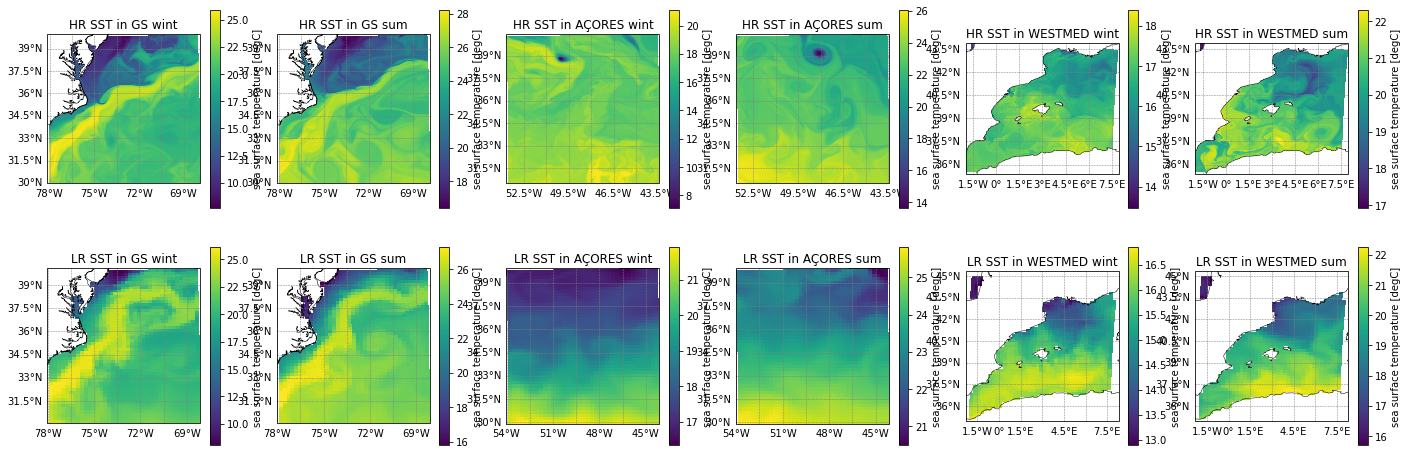

In [13]:
fig, axis = plt.subplots(ncols=len(data), nrows=2, figsize=(24,8), subplot_kw={'projection': ccrs.PlateCarree()})
for col in range(len(data)) :
    for row, dataSetKey in enumerate(['HR', 'LR']) :
        data[col][dataSetKey].isel(time_counter=-1).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=dataSetKey + ' SST in ' + data[col]['label'])

for ax in axis.flatten() :
    ax.coastlines(color='k', lw=0.5)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

In [14]:
# fig, axis = plt.subplots(ncols=2, nrows=len(data), figsize=(5*len(data),8), subplot_kw={'projection': ccrs.PlateCarree()})
# for row in range(len(data)) :
#     for col, dataSetKey in enumerate(['HR', 'LR']) :
#         data[row][dataSetKey].isel(time_counter=-1).sosaline[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
#         axis[row,col].set(title=dataSetKey + ' surafce salinity in ' + data[row]['label'])

# for ax in axis.flatten() :
#     ax.coastlines(color='k', lw=0.5)
#     gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
#     gl.top_labels = False; gl.right_labels = False

# Density

Compute conservative temperature and density anomaly $\sigma_0$ with the use of `gsw` library:

In [15]:
%%time
for i in range(len(data)) :
    for dataKey in ['HR', 'LR'] :
        data[i][dataKey]['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, data[i][dataKey]['sosaline'], data[i][dataKey]['sosstsst'], dask='parallelized').compute()
        data[i][dataKey]['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, data[i][dataKey]['sosaline'], data[i][dataKey]['CT'], dask='parallelized').compute()
        data[i][dataKey]['CT_sqr'] = data[i][dataKey]['CT']**2

CPU times: user 1.28 s, sys: 384 ms, total: 1.66 s
Wall time: 1.9 s


# Filters

## Routines

In [16]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    new_e2t = data['e2t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    
    # binariwe and erode the mask (to remove isolated pixels)
    threshold = 0.9
    new_wetmask = ndimage.binary_erosion(np.where((result['tmask'] > threshold), 1.0, 0.0))
    result['tmask'] = (['y','x'], new_wetmask.astype(np.float32))
    # apply new mask to data
    result = result.where(result.tmask>0)
    return result

In [17]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    wet_mask = xr.DataArray(dataHR.tmask, dims=['y','x'])
    area = xr.DataArray((dataHR.e1t * dataHR.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(dataHR.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(dataHR.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(dataHR.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(dataHR.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            n_iterations=2,
            filter_scale=filter_scale,    
             dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=dataHR.coords)
        data_filtered = gaussian_filter.apply(dataHR, dims=['y', 'x'])
    else :
        data_filtered = dataHR
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

## Set of filters to compare

In [18]:
coarsening_window_size = 15
filters = [dict({'filter_coef' : 0, 'coarsening_window_size' : coarsening_window_size, 'label' : 'Coarse 15'}),
          dict({'filter_coef' : 15, 'coarsening_window_size' : coarsening_window_size, 'label' : 'Filter 15 + Coarse 15'}),
          dict({'filter_coef' : 22.5, 'coarsening_window_size' : coarsening_window_size, 'label' : 'Filter 22.5 + Coarse 15'}),
          dict({'filter_coef' : 30, 'coarsening_window_size' : coarsening_window_size, 'label' : 'Filter 30 + Coarse 15'})]

In [19]:
%%time
for i in range(len(data)) : 
    data[i]['HR_Filtered'] = [] 
    for ifilter, curr_filter in enumerate(filters) :
        data[i]['HR_Filtered'].append(apply_filter_downsample(data[i]['HR'], curr_filter['filter_coef'], curr_filter['coarsening_window_size']).compute().\
                                                               chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}))

CPU times: user 10min 35s, sys: 5min 18s, total: 15min 54s
Wall time: 15min 46s


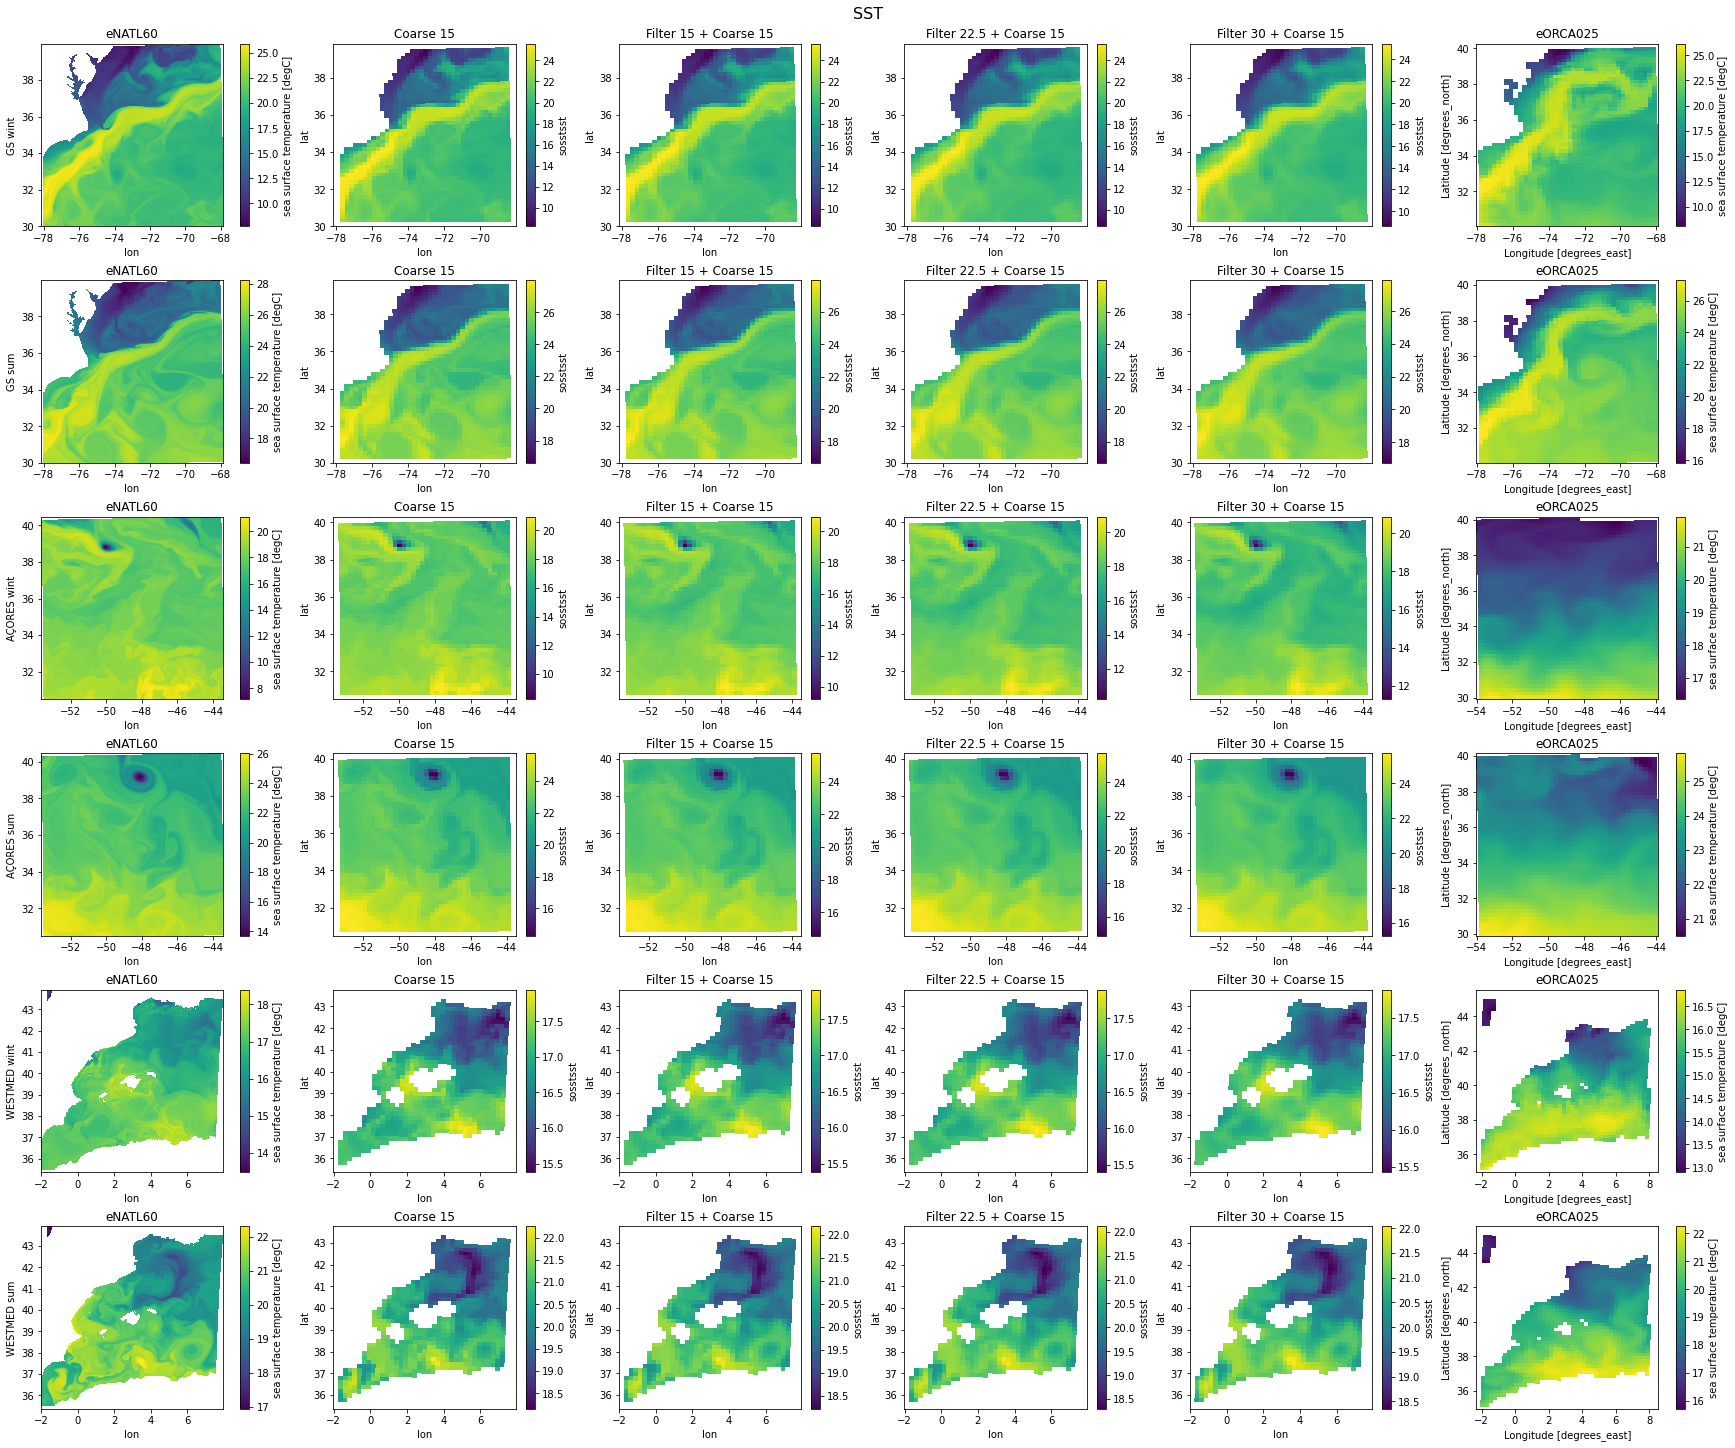

In [20]:
fig, axis = plt.subplots(ncols=6, nrows=6, figsize=(24,20), constrained_layout=True)
quantity='sosstsst'
fig.suptitle('SST', size=16)
for row in range(len(data)) :
    data[row]['HR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,0])
    axis[row,0].set(title='eNATL60')
    for ifilter in range(len(filters)) :
        col = ifilter+1
        data[row]['HR_Filtered'][ifilter].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=filters[ifilter]['label'])
    data[row]['LR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,-1])
    axis[row,-1].set(title='eORCA025')    
    axis[row,0].set(ylabel=data[row]['label'])

# Histograms

## General routines

In [82]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
        bins2 = np.linspace(dataSet[var2].min(), dataSet[var2].max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t).where(dataSet.tmask >0), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum()).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), dataSet[var2].fillna(0), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = hist/hist.sum()
    return norm_hist

In [83]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

# plotting routine
def margin_hist(data, color_index, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmaps_list[color_index], shading='auto', alpha=0.75)
    if 'slope' in data.attrs :
        ax_big.plot(data[x_bins], data.attrs['slope']*data[x_bins]+data.attrs['increment'], color=line_colors[color_index])
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x, color=line_colors[color_index])
    ax_histx.set(yscale='log', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins], color=line_colors[color_index])
    ax_histy.set(xscale='log', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

In [63]:
def fit_2D_histogram(hist_ds) :
    x_key = list(hist_ds.coords.keys())[0]
    y_key = list(hist_ds.coords.keys())[1]
    x=hist_ds[x_key]
    y=hist_ds[y_key]
    x_grid, y_grid = np.meshgrid(x, y, indexing='ij')
    x_vec = x_grid.flatten()
    y_vec = y_grid.flatten()
    weights = hist_ds.values.flatten()/np.sum(hist_ds.values)
    fitting_poly = P.polyfit(x_vec,y_vec,1,w=weights,full=True)
    slope = fitting_poly[0][1]
    increment = fitting_poly[0][0]
    resid = fitting_poly[1][0][0]
    mean_x = np.mean(x_grid*hist_ds.values)/np.sum(hist_ds.values)
    mean_y = np.mean(y_grid*hist_ds.values)/np.sum(hist_ds.values)
    return [slope, increment, resid, mean_x, mean_y]

In [64]:
nb_of_bins = 150

In [65]:
# initialize data structure for storing histograms
hists=[dict() for i in range(len(data))]
for i in range(len(data)) :
    hists[i]['HR_Filtered'] = [dict({'label' : filters[i]['label']}) for i in range(len(filters))] 
    hists[i]['HR'] = dict({'label' : 'eNATL60'})
    hists[i]['LR'] = dict({'label' : 'eORCA025'})

## Histograms of spatial grads

### Compute gradients

In [66]:
def gradx(dataArray, delta_x) :
    return (dataArray.shift(x=-1) - dataArray)/delta_x
def grady(dataArray, delta_y) :
    return (dataArray.shift(y=-1) - dataArray)/delta_y

In [67]:
def diffx(dataArray) :
    return (dataArray.shift(x=-1) - dataArray)
def diffy(dataArray) :
    return (dataArray.shift(y=-1) - dataArray)

In [68]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR']] + [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds["alpha"], ds["beta"] = eos_module.alpha_beta(ds["sosaline"], ds["CT"])
        ds['rho_sa_sa'], ds['rho_sa_ct'], ds['rho_ct_ct'] = eos_module.rho_second_derivatives(ds['sosaline'], ds['CT'])
        ds['gradx_temp'] = gradx(ds['CT'], ds['e1t'])
        ds['grady_temp'] = grady(ds['CT'], ds['e2t'])
        ds['gradx_sal'] = gradx(ds['sosaline'], ds['e1t'])
        ds['grady_sal'] = grady(ds['sosaline'], ds['e2t'])
        ds['grad_temp_sqr'] = (ds['gradx_temp']**2 + ds['grady_temp']**2).compute()
        ds['grad_sal_sqr'] = (ds['gradx_sal']**2 + ds['grady_sal']**2).compute()
        ds['grad_temp'] = np.sqrt(ds['grad_temp_sqr'])
        ds['grad_sal'] = np.sqrt(ds['grad_sal_sqr'])
        # ds['alpha_nablaT'] = (ds['alpha']*ds['grad_temp']).compute()
        # ds['beta_nablaS'] = (ds['beta']*ds['grad_sal']).compute()
        # ds['spicyness'] = np.sqrt((ds['alpha']*ds['gradx_temp']+ds['beta']*ds['gradx_sal'])**2+(ds['alpha']*ds['grady_temp']+ds['beta']*ds['grady_sal'])**2)
        # ds['buoyancy'] = np.sqrt((ds['alpha']*ds['gradx_temp']-ds['beta']*ds['gradx_sal'])**2+(ds['alpha']*ds['grady_temp']-ds['beta']*ds['grady_sal'])**2)
        # ds['temp_second_deriv'] = (ds['rho_ct_ct']*ds['grad_temp_sqr']).compute()
        # ds['mixed_second_deriv'] = (ds['rho_sa_ct']*ds['grad_temp']*ds['grad_sal']).compute()
        # ds['sal_second_deriv'] = (ds['rho_sa_sa']*ds['grad_sal_sqr']).compute()
        # ds['total_second_deriv'] = ds['temp_second_deriv']+2.*ds['mixed_second_deriv']+ds['sal_second_deriv']

CPU times: user 19 s, sys: 12.7 s, total: 31.7 s
Wall time: 36.7 s


### Compute histograms of grads

In [84]:
%%time
name_hist = 'hist_grads_x'
x = 'gradx_sal'
y = 'gradx_temp'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    ref_hist = compute_2D_histogram(data[i]['HR_Filtered'][ref_case].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), x, y, nb_of_bins).compute()
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataKey in ['HR','LR'] :
        hists[i][dataKey][name_hist] = compute_2D_histogram(data[i][dataKey].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), x, y, nb_of_bins, bins=bins).compute()
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), \
                                                                           x, y, nb_of_bins, bins=bins).compute()

CPU times: user 6 s, sys: 4.55 s, total: 10.6 s
Wall time: 26.8 s


In [96]:
%%time
name_hist = 'hist_grads_y'
x = 'grady_sal'
y = 'grady_temp'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    ref_hist = compute_2D_histogram(data[i]['HR_Filtered'][ref_case].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), x, y, nb_of_bins).compute()
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataKey in ['HR','LR'] :
        hists[i][dataKey][name_hist] = compute_2D_histogram(data[i][dataKey].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), x, y, nb_of_bins, bins=bins).compute()
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), \
                                                                           x, y, nb_of_bins, bins=bins).compute()

CPU times: user 6.05 s, sys: 4.56 s, total: 10.6 s
Wall time: 26.6 s


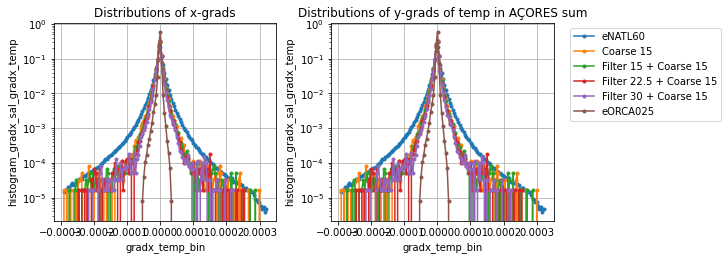

In [104]:
fig, ax = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10,3.5))
region=3
for ds in [hists[region]['HR']] + [hists[region]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [hists[region]['LR']] :
    ds['hist_grads_x'].sum(dim='gradx_sal_bin').plot(ax=ax[0], label=ds['label'], ls='-', marker='.')
    ds['hist_grads_x'].sum(dim='gradx_sal_bin').plot(ax=ax[1], label=ds['label'], ls='-', marker='.')
for axis in ax :
    axis.set(yscale='log', xscale='linear')
    axis.grid(True)
ax[0].set(title='Distributions of x-grads')
ax[1].set(title='Distributions of y-grads of temp in '+data[region]['label'])
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Comparison between histograms (scores)

#### KL divergence

Kullback-Leibler (KL) divergence (or relative entropy) 
$$ D_{KL} (P || Q) = \sum_i P(i) \log\frac{P(i)}{Q(i)} $$
a measure of how one probability distribution $Q$ is different from a second, reference probability distribution $P$ (information gain of $P$ in comparison to $Q$). In other words, it is the amount of information lost when $Q$ is used to approximate $P$.

In [206]:
def D_KL(hist_P, hist_Q) :
    masked_P = np.where(hist_P >0, hist_P, np.NaN)
    masked_Q = np.where(hist_Q >0, hist_Q, np.NaN)
    return np.nansum(masked_P*(np.log(masked_P/masked_Q)))

Symmertrized KL divergence (Jeffreys divergence):
$$ D_{sym} (P || Q) = D_{KL} (P || Q) + D_{KL} (Q || P) $$

In [207]:
def D_sym(hist_P, hist_Q) :
    return KL_divergence(hist_P, hist_Q)+KL_divergence(hist_Q, hist_P)

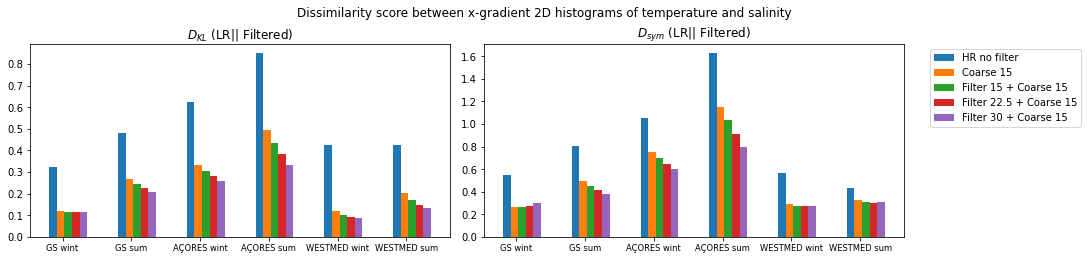

In [227]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Dissimilarity score between x-gradient 2D histograms of temperature and salinity')
name_hist = 'hist_grads_x'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
ax[0].bar(x, [D_KL(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width)
ax[1].bar(x, [D_sym(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width, label='HR no filter')
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+1)*bar_width, [D_KL(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+1)*bar_width, [D_sym(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], \
              width=bar_width, label=filters[ifilter]['label'])
ax[0].set_xticks(x + 1.25*bar_width)
ax[0].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax[0].xaxis.set_tick_params(labelsize='small')
ax[0].set(title=r'$D_{KL}$ ('+ ref_dataKey +'|| Filtered)')
ax[0].set(yscale='linear')
    
ax[1].set_xticks(x + 1.25*bar_width)
ax[1].set_xticklabels([data[region]['label'] for region in range(len(data))])
ax[1].xaxis.set_tick_params(labelsize='small')
ax[1].set(title=r'$D_{sym}$ ('+ ref_dataKey +'|| Filtered)')
ax[1].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### B-distrance

- Bhattacharyya distance (to estimate overlap between two distributions):
$$ D_B(P,Q) = -\log[BC(P,Q)] $$
$$ BC(P,Q) = \sum_i \sqrt{P(i) Q(i)} $$
- Helliger distance:
$$D_H (P,Q) = \sqrt{1-BC(P,Q)}$$ 
is limited $0<D_H (P,Q)<1$ 

In [209]:
def BC(hist_P, hist_Q) :
    return np.nansum(np.sqrt(hist_P*hist_Q))

def D_H(hist_P, hist_Q) :
    return np.sqrt(1.-BC(hist_P,hist_Q))

def D_B(hist_P, hist_Q) :
    return -np.log(BC(hist_P,hist_Q))

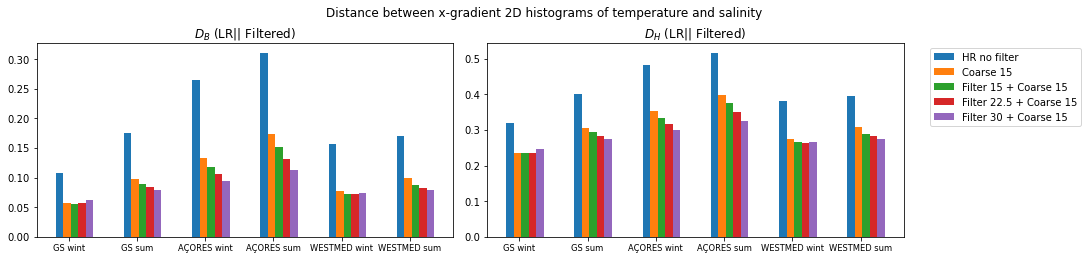

In [226]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Distance between x-gradient 2D histograms of temperature and salinity')
name_hist = 'hist_grads_x'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
ax[0].bar(x, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width)
ax[1].bar(x, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width, label='HR no filter')
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+1)*bar_width, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+1)*bar_width, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], width=bar_width, \
              label=filters[ifilter]['label'])
ax[0].set_xticks(x + 1.25*bar_width)
ax[0].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax[0].xaxis.set_tick_params(labelsize='small')
ax[0].set(title=r'$D_B$ ('+ ref_dataKey +'|| Filtered)')
ax[0].set(yscale='linear')
    
ax[1].set_xticks(x + 1.25*bar_width)
ax[1].set_xticklabels([data[region]['label'] for region in range(len(data))])
ax[1].xaxis.set_tick_params(labelsize='small')
ax[1].set(title=r'$D_H$ ('+ ref_dataKey +'|| Filtered)')
ax[1].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Structure functions

In [276]:
def compute_structure_functions(dataArr, key_field) :
    N = len(dataArr['x'])
    #nb_of_shifts = N//2-1
    nb_of_shifts = 25
    vectorS1 = np.zeros(nb_of_shifts)
    vectorS2 = np.zeros(nb_of_shifts)
    vectorS3 = np.zeros(nb_of_shifts)
    distance = np.zeros(nb_of_shifts)
    for index,index_shift in enumerate(range(0,nb_of_shifts)) :
        cut=slice(1,N-index_shift)
        shiftedArr = dataArr[key_field].roll(x=-index_shift,roll_coords=False)
        difference = dataArr[key_field][cut] - shiftedArr[cut]
        vectorS1[index] = difference.mean().values
        vectorS2[index] = (difference**2).mean().values
        vectorS3[index] = (difference**3).mean().values
        distance[index] = dataArr.isel(x=slice(0,index_shift)).e1t.sum(dim='x').mean(dim='y').values
    stucture_functions_dataset = xr.Dataset(data_vars={'S1' : xr.DataArray(vectorS1, dims=["shift"]),\
                                             'S2' : xr.DataArray(vectorS2, dims=["shift"]),\
                                             'S3' : xr.DataArray(vectorS3, dims=["shift"])}, \
                                            coords={'shift' : np.arange(0,nb_of_shifts),\
                                                   'shift_distance' : ('shift', distance/1000)})
    return stucture_functions_dataset

In [277]:
# initialize data structure for storing histograms
str_fun=[dict() for i in range(len(data))]
for i in range(len(data)) :
    str_fun[i]['HR_Filtered'] = [dict({'label' : filters[i]['label']}) for i in range(len(filters))] 
    str_fun[i]['HR'] = dict({'label' : 'eNATL60'})
    str_fun[i]['LR'] = dict({'label' : 'eORCA025'})

In [278]:
%%time 
for i in range(len(data)) :
    str_fun[i]['LR']['temp_str_fun'] = compute_structure_functions(data[i]['LR'],'CT')
    for ifilter in range(len(filters)) :
        str_fun[i]['HR_Filtered'][ifilter]['temp_str_fun'] = compute_structure_functions(data[i]['HR_Filtered'][ifilter],'CT')

CPU times: user 23.8 s, sys: 901 ms, total: 24.7 s
Wall time: 2min 14s


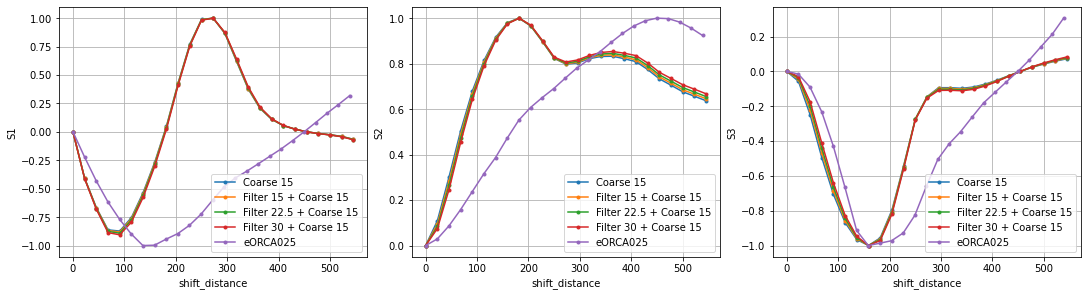

In [279]:
fig, ax = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15,4))
i=0
for index, data_key in enumerate(['S1', 'S2', 'S3']) :
    for ds in [str_fun[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [str_fun[i]['LR']] :
        data_to_plot = ds['temp_str_fun'][data_key]
        data_to_plot = data_to_plot/(np.abs(data_to_plot).max())
        data_to_plot.plot(ax=ax[index], x='shift_distance', label=ds['label'], marker='.')
    ax[index].set(yscale='linear', xscale='linear'); ax[index].grid(True)
    ax[index].legend()
plt.show()

# Spectra